# 01 — Linear Regression for L/D Prediction

This notebook explores **Ordinary Least Squares (OLS)** and **SGD-based linear regression** for predicting the lift-to-drag ratio (L/D) of **NACA 4-digit airfoils** from the AirfRANS dataset.

---

## Dataset

489 NACA 4-digit airfoil simulations from AirfRANS, split using the official manifest:
- **378 training samples**
- **111 test samples**

## Feature Definitions

| Feature | Meaning | Range |
|---------|---------|-------|
| `Reynolds` | **Reynolds number** — $Re = V \cdot L / \nu$ | 2.0M – 6.0M |
| `angle_of_attack_rad` | **Angle of attack** (radians) | −0.09 to +0.26 |
| `camber` | **Max camber** (% of chord) | 0 – 7 |
| `camber_pos` | **Position of max camber** (tenths of chord) | 0 – 7 |
| `thickness` | **Max thickness** (% of chord) | 5 – 20 |

---

In [ ]:
from __future__ import annotations

from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ─────────────────────────────────────────────────────────────────────────────
# Repo-root discovery so `import src...` works regardless of cwd
# ─────────────────────────────────────────────────────────────────────────────
def _find_repo_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / 'src').is_dir():
            return p
    raise RuntimeError(f"Could not find repo root from: {start}")

REPO_ROOT = _find_repo_root(Path.cwd())
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

from src.config import DATA_DIR, RAW_DATASET_DIR
from src.tabular_data import load_airfrans_tabular_split

# ─────────────────────────────────────────────────────────────────────────────
# Load data
# ─────────────────────────────────────────────────────────────────────────────
csv_path = DATA_DIR / 'airfrans_dataset.csv'
manifest_path = RAW_DATASET_DIR / 'manifest.json'
task = 'full'

train_df, test_df = load_airfrans_tabular_split(csv_path, manifest_path, task=task)

# Clean, physically meaningful features for NACA 4-digit airfoils
FEATURE_LABELS = {
    'Reynolds': 'Reynolds Number',
    'angle_of_attack_rad': 'Angle of Attack (rad)',
    'camber': 'Max Camber (%)',
    'camber_pos': 'Camber Position (tenths)',
    'thickness': 'Max Thickness (%)',
}
feature_cols = list(FEATURE_LABELS.keys())
target_col = 'L_D'

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")
print(f"Features: {feature_cols}")
print(f"\nReynolds range: {train_df['Reynolds'].min()/1e6:.2f}M – {train_df['Reynolds'].max()/1e6:.2f}M")
print(f"AoA range: {np.degrees(train_df['angle_of_attack_rad'].min()):.1f}° – {np.degrees(train_df['angle_of_attack_rad'].max()):.1f}°")

# ─────────────────────────────────────────────────────────────────────────────
# Linear Regression via Stochastic Gradient Descent
# ─────────────────────────────────────────────────────────────────────────────
# Pure gradient descent with NO regularization
# Using constant learning rate and running until convergence

pre = Pipeline([
    ('scaler', StandardScaler()),
])

model = SGDRegressor(
    loss='squared_error',        # MSE loss = linear regression
    penalty=None,                # NO regularization — pure linear regression
    max_iter=100000,             # Let it run for many iterations
    tol=1e-6,                    # Very tight convergence tolerance
    learning_rate='constant',    # Fixed learning rate
    eta0=0.001,                  # Small, stable learning rate
    random_state=42,
    verbose=0,
)

pipe = Pipeline([('pre', pre), ('model', model)])
pipe.fit(X_train, y_train)

y_train_pred = np.asarray(pipe.predict(X_train)).reshape(-1)
y_test_pred = np.asarray(pipe.predict(X_test)).reshape(-1)
y_train_np = np.asarray(y_train).reshape(-1)
y_test_np = np.asarray(y_test).reshape(-1)

print(f"\nConverged in {model.n_iter_} iterations")

metrics = {
    'R² (train)': r2_score(y_train_np, y_train_pred),
    'R² (test)': r2_score(y_test_np, y_test_pred),
    'MAE (test)': mean_absolute_error(y_test_np, y_test_pred),
    'RMSE (test)': np.sqrt(mean_squared_error(y_test_np, y_test_pred)),
}
pd.DataFrame([metrics]).T.rename(columns={0: 'Value'}).round(4)

Train samples: 378, Test samples: 111
Features: ['Reynolds', 'angle_of_attack_rad', 'camber', 'camber_pos', 'thickness']

Reynolds range: 2.02M – 6.03M
AoA range: -4.9° – 14.8°

Converged in 25 iterations


,Value
R² (train),0.6730
R² (test),0.6036
MAE (test),16.8229
RMSE (test),21.2843


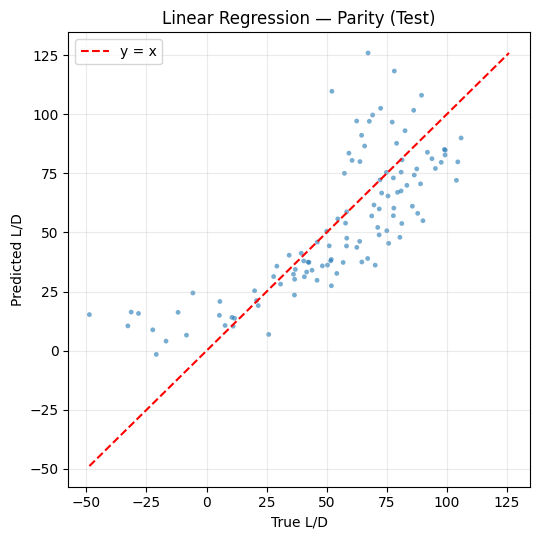

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Parity plot (true vs predicted)
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(5.5, 5.5))
plt.scatter(y_test_np, y_test_pred, s=12, alpha=0.6, edgecolors='none')
mn = float(min(y_test_np.min(), y_test_pred.min()))
mx = float(max(y_test_np.max(), y_test_pred.max()))
plt.plot([mn, mx], [mn, mx], 'r--', lw=1.5, label='y = x')
plt.xlabel('True L/D')
plt.ylabel('Predicted L/D')
plt.title('Linear Regression — Parity (Test)')
plt.legend()
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

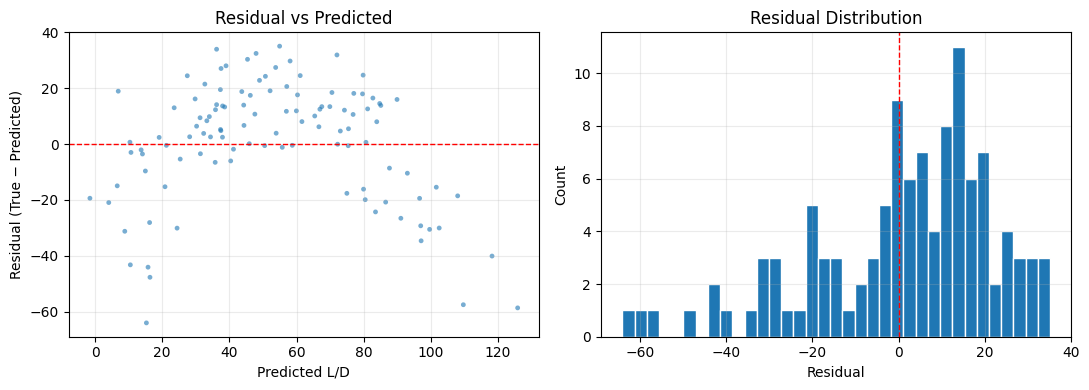

Residual mean: 0.934, std: 21.264


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Residual diagnostics
# ─────────────────────────────────────────────────────────────────────────────
resid = y_test_np - y_test_pred

fig, ax = plt.subplots(1, 2, figsize=(11, 4))

ax[0].scatter(y_test_pred, resid, s=12, alpha=0.6, edgecolors='none')
ax[0].axhline(0, color='red', linestyle='--', lw=1)
ax[0].set_xlabel('Predicted L/D')
ax[0].set_ylabel('Residual (True − Predicted)')
ax[0].set_title('Residual vs Predicted')
ax[0].grid(True, alpha=0.25)

ax[1].hist(resid, bins=35, edgecolor='white')
ax[1].axvline(0, color='red', linestyle='--', lw=1)
ax[1].set_xlabel('Residual')
ax[1].set_ylabel('Count')
ax[1].set_title('Residual Distribution')
ax[1].grid(True, alpha=0.25)

plt.tight_layout()
plt.show()

print(f"Residual mean: {resid.mean():.3f}, std: {resid.std():.3f}")

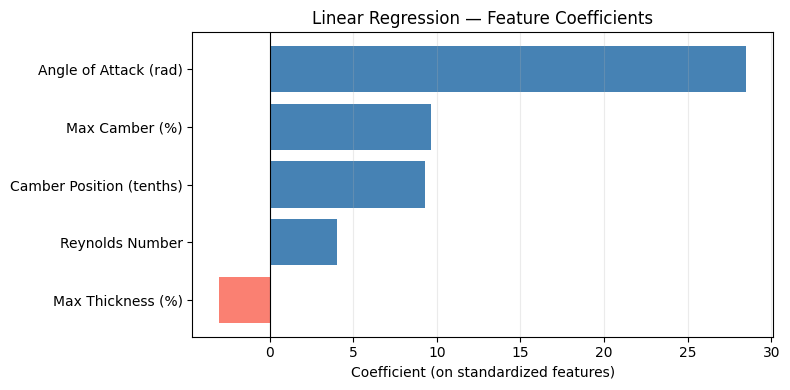

,Feature,Coefficient
0,Angle of Attack (rad),28.502869
1,Max Camber (%),9.637145
2,Camber Position (tenths),9.274279
3,Reynolds Number,4.018070
4,Max Thickness (%),-3.032417


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Feature coefficients (standardized scale → relative importance)
# ─────────────────────────────────────────────────────────────────────────────
coef = pipe.named_steps['model'].coef_
coef_df = pd.DataFrame({
    'Feature': [FEATURE_LABELS[c] for c in feature_cols],
    'Coefficient': coef
}).sort_values('Coefficient', key=abs, ascending=False)

plt.figure(figsize=(8, 4))
colors = ['steelblue' if c >= 0 else 'salmon' for c in coef_df['Coefficient']]
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors)
plt.axvline(0, color='black', lw=0.8)
plt.xlabel('Coefficient (on standardized features)')
plt.title('Linear Regression — Feature Coefficients')
plt.gca().invert_yaxis()
plt.grid(True, axis='x', alpha=0.25)
plt.tight_layout()
plt.show()

coef_df.reset_index(drop=True)

---

## Learning Rate Sensitivity

We sweep the learning rate (η) to understand how gradient descent convergence affects model performance. No regularization is used — this is pure linear regression via SGD.

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Learning Rate Sweep (NO regularization)
# ─────────────────────────────────────────────────────────────────────────────
learning_rates = np.logspace(-5, 0, 20)  # 1e-5 to 1.0

def fit_sgd_lr(eta0: float) -> dict:
    """Fit SGD with given learning rate, NO regularization."""
    sgd = SGDRegressor(
        loss='squared_error',
        penalty=None,              # NO regularization
        learning_rate='constant',
        eta0=eta0,
        max_iter=100000,
        tol=1e-6,
        random_state=42,
    )
    pipe_sgd = Pipeline([('pre', pre), ('model', sgd)])
    pipe_sgd.fit(X_train, y_train)
    
    y_pred_train = pipe_sgd.predict(X_train)
    y_pred_test = pipe_sgd.predict(X_test)
    
    n_train = len(y_train)
    n_test = len(y_test)
    p = len(feature_cols)
    
    # R² and Adjusted R²
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    r2_adj_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p - 1)
    r2_adj_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p - 1)
    
    return {
        'eta0': eta0,
        'n_iter': sgd.n_iter_,
        'r2_train': r2_train,
        'r2_test': r2_test,
        'r2_adj_train': r2_adj_train,
        'r2_adj_test': r2_adj_test,
        'rmse_test': np.sqrt(mean_squared_error(y_test, y_pred_test)),
    }

lr_results = pd.DataFrame([fit_sgd_lr(lr) for lr in learning_rates])
lr_results.sort_values('r2_adj_test', ascending=False).head(10)

,eta0,n_iter,r2_train,r2_test,r2_adj_train,r2_adj_test,rmse_test
8,0.001274,25,0.673001,0.603785,0.668606,0.584918,21.278734
9,0.002336,13,0.672981,0.603724,0.668585,0.584854,21.280357
6,0.000379,60,0.673009,0.603414,0.668614,0.584528,21.288704
7,0.000695,29,0.673005,0.603376,0.668610,0.584490,21.289700
4,0.000113,172,0.673009,0.603294,0.668614,0.584403,21.291913
3,0.000062,324,0.673009,0.603290,0.668614,0.584400,21.292006
0,0.000010,2021,0.673009,0.603289,0.668614,0.584398,21.292058
2,0.000034,604,0.673009,0.603288,0.668614,0.584397,21.292062
1,0.000018,1148,0.673010,0.603284,0.668615,0.584393,21.292180
5,0.000207,104,0.673010,0.603265,0.668615,0.584373,21.292680


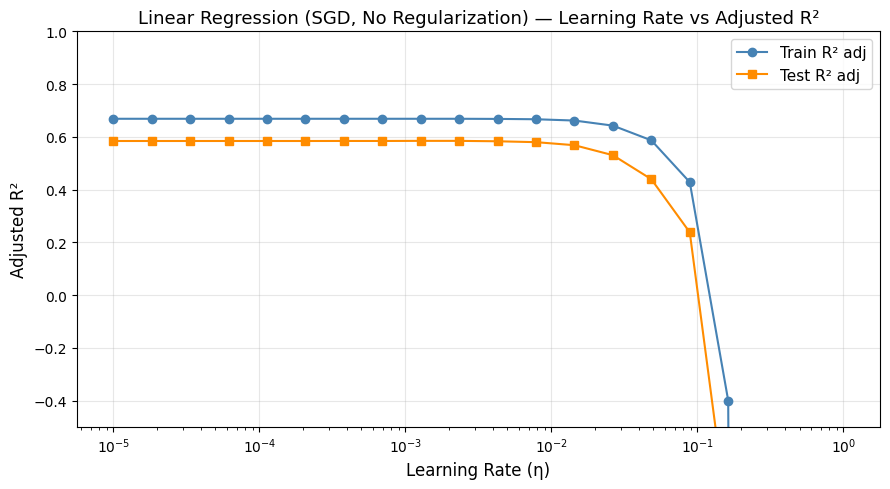

Best learning rate: η = 1.27e-03
  Converged in 25 iterations
  Train R² adj = 0.6686
  Test R² adj  = 0.5849


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Plot: Learning Rate vs Adjusted R²
# ─────────────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(9, 5))

ax.plot(lr_results['eta0'], lr_results['r2_adj_train'], 'o-', label='Train R² adj', color='steelblue')
ax.plot(lr_results['eta0'], lr_results['r2_adj_test'], 's-', label='Test R² adj', color='darkorange')

ax.set_xscale('log')
ax.set_xlabel('Learning Rate (η)', fontsize=12)
ax.set_ylabel('Adjusted R²', fontsize=12)
ax.set_title('Linear Regression (SGD, No Regularization) — Learning Rate vs Adjusted R²', fontsize=13)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.5, 1.0)

plt.tight_layout()
plt.show()

# Best learning rate
best_lr = lr_results.loc[lr_results['r2_adj_test'].idxmax()]
print(f"Best learning rate: η = {best_lr['eta0']:.2e}")
print(f"  Converged in {int(best_lr['n_iter'])} iterations")
print(f"  Train R² adj = {best_lr['r2_adj_train']:.4f}")
print(f"  Test R² adj  = {best_lr['r2_adj_test']:.4f}")

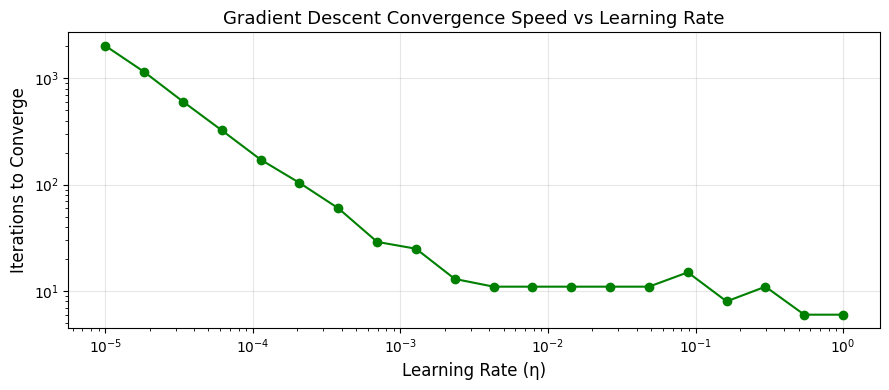

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Plot: Learning Rate vs Iterations to Converge
# ─────────────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(9, 4))

ax.plot(lr_results['eta0'], lr_results['n_iter'], 'o-', color='green')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Learning Rate (η)', fontsize=12)
ax.set_ylabel('Iterations to Converge', fontsize=12)
ax.set_title('Gradient Descent Convergence Speed vs Learning Rate', fontsize=13)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## Conclusions (Linear Regression Only)

### Final Linear regression Metrics (Best Observed)
- Learning rate (η): 0.001274
- Converged iterations: 25
- Train adjusted $R^2$: 0.668606
- Test adjusted $R^2$: 0.584918
- Test RMSE: 21.278734

### Key Deductions
- A linear model captures some of the global trend in $L/D$ (moderate test adjusted $R^2$), but leaves substantial error, indicating important structure is not representable by a purely linear function of the five features.
- The remaining error is consistent with the underlying aerodynamics being strongly nonlinear (e.g., nonlinear lift response with angle of attack, induced drag scaling with lift, and stall/transition effects), which a linear hypothesis class cannot model.
- The learning-rate sweep shows performance is relatively stable across a broad η range, but the best η (0.001274) provides the strongest test adjusted $R^2$ while converging quickly (25 iterations).